# Etapa 4b - Modelos predictivos Andes

Importar librerias necesarias

In [2]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import (mean_squared_error,mean_absolute_error,r2_score,classification_report,confusion_matrix,)

import joblib
import matplotlib.pyplot as plt

Configuración y carga de datos

In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

DATA_PATH = "base_final_con_recomendacion.csv"

df = pd.read_csv(DATA_PATH)
print("Shape original:", df.shape)
df.head()

Shape original: (61467, 55)


,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,...,neighbourhood_cleansed_East,neighbourhood_cleansed_North,neighbourhood_cleansed_South,neighbourhood_cleansed_West,property_type_Other,property_type_Private Room,room_type_Hotel room,room_type_Private room,room_type_Shared room,recomended
0,1,1.0,1.0,1.0,70.0,1,29,1.0,1.0,29.0,...,0,1,0,0,0,1,0,1,0,0
1,2,1.0,1.0,1.0,149.0,4,30,4.0,4.0,30.0,...,0,0,0,0,0,0,0,0,0,0
2,6,2.0,3.0,3.0,411.0,3,365,3.0,3.0,365.0,...,0,0,0,0,0,0,0,0,0,0
3,4,1.0,1.0,0.0,210.0,5,1125,5.0,21.0,21.0,...,1,0,0,0,0,0,0,0,0,1
4,5,1.5,3.0,3.0,280.0,3,22,3.0,3.0,22.0,...,0,0,1,0,0,0,0,0,0,0


Preparación de datos

In [4]:
TARGET_REG = "price"
TARGET_CLF = "recomended"

FEATURE_COLS = [c for c in df.columns if c not in [TARGET_REG, TARGET_CLF]]
print("Número de features:", len(FEATURE_COLS))

N_SAMPLE = min(10000, len(df))
df_sample = df.sample(n=N_SAMPLE, random_state=SEED)
print("Shape muestra:", df_sample.shape)

X = df_sample[FEATURE_COLS].values
y_reg = df_sample[TARGET_REG].values
y_clf = df_sample[TARGET_CLF].values

Número de features: 53
Shape muestra: (10000, 55)


División en entrenamiento y prueba + escalado

In [5]:
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=SEED
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "scaler_airbnb_london.pkl")

X_train: (8000, 53) X_test: (2000, 53)


['scaler_airbnb_london.pkl']

## MLP de regresión (precio)

### Modelo 1 - Arquitectura base: Capa de entrada con todas las features, 2 capas densas ocultas (32 y 16 neuronas, ReLU) y una Capa de salida con 1 neurona (precio en GBP).

In [6]:
reg_mlp = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    solver="adam",
    random_state=SEED,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    verbose=True  # para ver progreso
)

reg_mlp.fit(X_train_scaled, y_reg_train)

Iteration 1, loss = 50790.97048742
Validation score: -0.923503
Iteration 2, loss = 50426.10740456
Validation score: -0.896009
Iteration 3, loss = 49610.47633347
Validation score: -0.835020
Iteration 4, loss = 47916.57683127
Validation score: -0.721808
Iteration 5, loss = 45068.65212004
Validation score: -0.541620
Iteration 6, loss = 40843.28182248
Validation score: -0.309214
Iteration 7, loss = 35760.58079557
Validation score: -0.045662
Iteration 8, loss = 30447.64830064
Validation score: 0.171409
Iteration 9, loss = 26398.25183875
Validation score: 0.310946
Iteration 10, loss = 24004.87522912
Validation score: 0.365023
Iteration 11, loss = 22933.49156057
Validation score: 0.382488
Iteration 12, loss = 22489.45452956
Validation score: 0.388538
Iteration 13, loss = 22196.15352953
Validation score: 0.394059
Iteration 14, loss = 21984.46527940
Validation score: 0.401740
Iteration 15, loss = 21821.90144987
Validation score: 0.405039
Iteration 16, loss = 21669.05382757
Validation score: 0.4

,loss,'squared_error'
,hidden_layer_sizes,"(32, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True


#### Evaluación regresión

In [7]:
y_reg_pred = reg_mlp.predict(X_test_scaled)

mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test, y_reg_pred)

print("\n=== Regresión (price) - MLP ===")
print(f"MSE  : {mse:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"MAE  : {mae:,.2f}")
print(f"R^2  : {r2:,.4f}")

joblib.dump(reg_mlp, "mlp_regresion_price_airbnb.pkl")


=== Regresión (price) - MLP ===
MSE  : 22,129.56
RMSE : 148.76
MAE  : 76.59
R^2  : 0.4309


['mlp_regresion_price_airbnb.pkl']

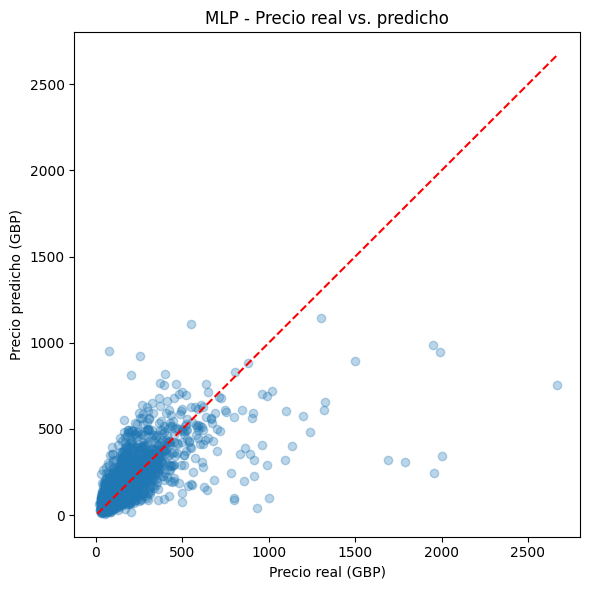

In [8]:
# Scatter real vs predicho
plt.figure(figsize=(6,6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.3)
plt.xlabel("Precio real (GBP)")
plt.ylabel("Precio predicho (GBP)")
plt.title("MLP - Precio real vs. predicho")
min_val = min(y_reg_test.min(), y_reg_pred.min())
max_val = max(y_reg_test.max(), y_reg_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.tight_layout()
plt.show()


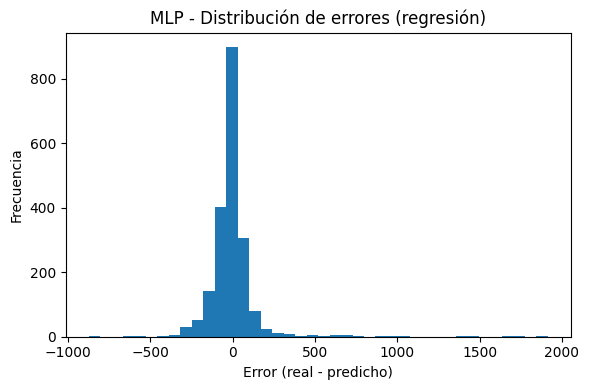

In [9]:
# Histograma de errores
residuals = y_reg_test - y_reg_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40)
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.title("MLP - Distribución de errores (regresión)")
plt.tight_layout()
plt.show()

### Modelo 2 - Arquitectura base: Capa de entrada con todas las features, 1 capa densa oculta (16 neuronas, ReLU) y una Capa de salida con 1 neurona (precio en GBP).

In [19]:
reg_mlp16 = MLPRegressor(
    hidden_layer_sizes=(16,),
    activation="relu",
    solver="adam",
    random_state=SEED,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    verbose=True
)

reg_mlp16.fit(X_train_scaled, y_reg_train)

Iteration 1, loss = 49180.10068085
Validation score: -0.711975
Iteration 2, loss = 49030.83898260
Validation score: -0.706474
Iteration 3, loss = 48878.30364597
Validation score: -0.700361
Iteration 4, loss = 48703.78431024
Validation score: -0.693300
Iteration 5, loss = 48500.08902893
Validation score: -0.685067
Iteration 6, loss = 48260.92197223
Validation score: -0.675509
Iteration 7, loss = 47981.82526992
Validation score: -0.664618
Iteration 8, loss = 47668.20152177
Validation score: -0.652008
Iteration 9, loss = 47308.51797262
Validation score: -0.638191
Iteration 10, loss = 46905.61405812
Validation score: -0.622334
Iteration 11, loss = 46445.48903607
Validation score: -0.603959
Iteration 12, loss = 45914.55011785
Validation score: -0.583155
Iteration 13, loss = 45320.74918380
Validation score: -0.560085
Iteration 14, loss = 44671.14148445
Validation score: -0.534514
Iteration 15, loss = 43953.39467573
Validation score: -0.507391
Iteration 16, loss = 43185.61652583
Validation sc

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,loss,'squared_error'
,hidden_layer_sizes,"(16,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True


In [20]:
y16_pred = reg_mlp16.predict(X_test_scaled)
mse16 = mean_squared_error(y_reg_test, y16_pred)
rmse16 = np.sqrt(mse16)
mae16 = mean_absolute_error(y_reg_test, y16_pred)
r2_16 = r2_score(y_reg_test, y16_pred)

print("=== Regresión MLP 1 capa (16 neuronas) ===")
print(f"RMSE: {rmse16:,.2f} | MAE: {mae16:,.2f} | R2: {r2_16:,.4f}")


=== Regresión MLP 1 capa (16 neuronas) ===
RMSE: 149.22 | MAE: 79.82 | R2: 0.4274


### Modelo 3 - Arquitectura base: Capa de entrada con todas las features, 1 capa densa oculta (32 neuronas, ReLU) y una Capa de salida con 1 neurona (precio en GBP).

In [21]:
reg_mlp32 = MLPRegressor(
    hidden_layer_sizes=(32,),
    activation="relu",
    solver="adam",
    random_state=SEED,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    verbose=True
)

reg_mlp32.fit(X_train_scaled, y_reg_train)

Iteration 1, loss = 47909.57863652
Validation score: -0.570528
Iteration 2, loss = 47666.44999945
Validation score: -0.562533
Iteration 3, loss = 47387.98790393
Validation score: -0.553013
Iteration 4, loss = 47038.01445900
Validation score: -0.541075
Iteration 5, loss = 46594.46035262
Validation score: -0.525701
Iteration 6, loss = 46026.78038026
Validation score: -0.507055
Iteration 7, loss = 45328.16079084
Validation score: -0.484010
Iteration 8, loss = 44478.67548265
Validation score: -0.457712
Iteration 9, loss = 43518.85637914
Validation score: -0.427322
Iteration 10, loss = 42426.08592256
Validation score: -0.394925
Iteration 11, loss = 41263.66947369
Validation score: -0.359630
Iteration 12, loss = 40017.26656817
Validation score: -0.322748
Iteration 13, loss = 38707.07953987
Validation score: -0.284807
Iteration 14, loss = 37378.22556679
Validation score: -0.245127
Iteration 15, loss = 36003.40691648
Validation score: -0.205954
Iteration 16, loss = 34634.65252606
Validation sc

,loss,'squared_error'
,hidden_layer_sizes,"(32,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True


In [22]:
y32_pred = reg_mlp32.predict(X_test_scaled)
mse32 = mean_squared_error(y_reg_test, y32_pred)
rmse32 = np.sqrt(mse32)
mae32 = mean_absolute_error(y_reg_test, y32_pred)
r2_32 = r2_score(y_reg_test, y32_pred)

print("\n=== Regresión MLP 1 capa (32 neuronas) ===")
print(f"RMSE: {rmse32:,.2f} | MAE: {mae32:,.2f} | R2: {r2_32:,.4f}")


=== Regresión MLP 1 capa (32 neuronas) ===
RMSE: 147.78 | MAE: 77.00 | R2: 0.4384


## MLP de clasificación (recomended)

### Modelo 1 - Arquitectura base: 2 capas densas ocultas (32 y 16 neuronas, ReLU) y una capa de salida con 1 neurona (sigmoide).

In [11]:
clf_mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    solver="adam",
    random_state=SEED,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    verbose=True
)

clf_mlp.fit(X_train_scaled, y_clf_train)

Iteration 1, loss = 0.61882149
Validation score: 0.793125
Iteration 2, loss = 0.45274443
Validation score: 0.800000
Iteration 3, loss = 0.36664566
Validation score: 0.840000
Iteration 4, loss = 0.30095404
Validation score: 0.890000
Iteration 5, loss = 0.24387465
Validation score: 0.913750
Iteration 6, loss = 0.19584271
Validation score: 0.927500
Iteration 7, loss = 0.15997568
Validation score: 0.937500
Iteration 8, loss = 0.13520158
Validation score: 0.938750
Iteration 9, loss = 0.11960361
Validation score: 0.941875
Iteration 10, loss = 0.10863800
Validation score: 0.943750
Iteration 11, loss = 0.10003478
Validation score: 0.944375
Iteration 12, loss = 0.09296257
Validation score: 0.947500
Iteration 13, loss = 0.08696637
Validation score: 0.949375
Iteration 14, loss = 0.08178597
Validation score: 0.950625
Iteration 15, loss = 0.07771571
Validation score: 0.952500
Iteration 16, loss = 0.07365501
Validation score: 0.956250
Iteration 17, loss = 0.07045522
Validation score: 0.954375
Iterat

,hidden_layer_sizes,"(32, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


#### Evaluación clasificación

In [12]:
y_clf_pred = clf_mlp.predict(X_test_scaled)

print("\n=== Clasificación (recomended) - MLP ===")
print(classification_report(y_clf_test, y_clf_pred, digits=3))
print("Matriz de confusión:")
print(confusion_matrix(y_clf_test, y_clf_pred))

joblib.dump(clf_mlp, "mlp_clasificacion_recomended_airbnb.pkl")


=== Clasificación (recomended) - MLP ===
              precision    recall  f1-score   support

           0      0.979     0.987     0.983      1592
           1      0.947     0.917     0.932       408

    accuracy                          0.973      2000
   macro avg      0.963     0.952     0.957      2000
weighted avg      0.972     0.973     0.972      2000

Matriz de confusión:
[[1571   21]
 [  34  374]]


['mlp_clasificacion_recomended_airbnb.pkl']

### Modelo 2 - Arquitectura base: 1 capa densa oculta (16 neuronas, ReLU) y una capa de salida con 1 neurona (sigmoide).

In [25]:
clf_mlp16 = MLPClassifier(
    hidden_layer_sizes=(16,),
    activation="relu",
    solver="adam",
    random_state=SEED,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    verbose=True
)

clf_mlp16.fit(X_train_scaled, y_clf_train)

Iteration 1, loss = 0.45479879
Validation score: 0.823125
Iteration 2, loss = 0.37664207
Validation score: 0.841250
Iteration 3, loss = 0.33192791
Validation score: 0.860625
Iteration 4, loss = 0.29705893
Validation score: 0.879375
Iteration 5, loss = 0.26633557
Validation score: 0.895625
Iteration 6, loss = 0.23974890
Validation score: 0.908750
Iteration 7, loss = 0.21685432
Validation score: 0.918750
Iteration 8, loss = 0.19715150
Validation score: 0.926250
Iteration 9, loss = 0.18046082
Validation score: 0.928750
Iteration 10, loss = 0.16648256
Validation score: 0.938125
Iteration 11, loss = 0.15518711
Validation score: 0.944375
Iteration 12, loss = 0.14512236
Validation score: 0.946250
Iteration 13, loss = 0.13636910
Validation score: 0.950625
Iteration 14, loss = 0.12914164
Validation score: 0.950625
Iteration 15, loss = 0.12251209
Validation score: 0.951875
Iteration 16, loss = 0.11670350
Validation score: 0.951875
Iteration 17, loss = 0.11156918
Validation score: 0.955000
Iterat

,hidden_layer_sizes,"(16,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


In [26]:
y16_pred_clf = clf_mlp16.predict(X_test_scaled)
print("=== Clasificación MLP 1 capa (16 neuronas) ===")
print(classification_report(y_clf_test, y16_pred_clf, digits=3))
print("Matriz de confusión:")
print(confusion_matrix(y_clf_test, y16_pred_clf))

=== Clasificación MLP 1 capa (16 neuronas) ===
              precision    recall  f1-score   support

           0      0.979     0.986     0.982      1592
           1      0.942     0.919     0.931       408

    accuracy                          0.972      2000
   macro avg      0.961     0.952     0.956      2000
weighted avg      0.972     0.972     0.972      2000

Matriz de confusión:
[[1569   23]
 [  33  375]]


### Modelo 3 - Arquitectura base: 1 capa densa oculta (32 neuronas, ReLU) y una capa de salida con 1 neurona (sigmoide).

In [27]:
clf_mlp32 = MLPClassifier(
    hidden_layer_sizes=(32,),
    activation="relu",
    solver="adam",
    random_state=SEED,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    verbose=True
)

clf_mlp32.fit(X_train_scaled, y_clf_train)

Iteration 1, loss = 0.55160028
Validation score: 0.787500
Iteration 2, loss = 0.41099171
Validation score: 0.826875
Iteration 3, loss = 0.34784739
Validation score: 0.860000
Iteration 4, loss = 0.30388264
Validation score: 0.889375
Iteration 5, loss = 0.26706230
Validation score: 0.908750
Iteration 6, loss = 0.23592807
Validation score: 0.928125
Iteration 7, loss = 0.20955923
Validation score: 0.931250
Iteration 8, loss = 0.18754975
Validation score: 0.940625
Iteration 9, loss = 0.16985760
Validation score: 0.945000
Iteration 10, loss = 0.15523063
Validation score: 0.946250
Iteration 11, loss = 0.14316868
Validation score: 0.951250
Iteration 12, loss = 0.13353997
Validation score: 0.951250
Iteration 13, loss = 0.12533268
Validation score: 0.953125
Iteration 14, loss = 0.11816123
Validation score: 0.953125
Iteration 15, loss = 0.11201875
Validation score: 0.953750
Iteration 16, loss = 0.10670029
Validation score: 0.955000
Iteration 17, loss = 0.10206001
Validation score: 0.957500
Iterat

,hidden_layer_sizes,"(32,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


In [28]:
y32_pred_clf = clf_mlp32.predict(X_test_scaled)
print("\n=== Clasificación MLP 1 capa (32 neuronas) ===")
print(classification_report(y_clf_test, y32_pred_clf, digits=3))
print("Matriz de confusión:")
print(confusion_matrix(y_clf_test, y32_pred_clf))


=== Clasificación MLP 1 capa (32 neuronas) ===
              precision    recall  f1-score   support

           0      0.984     0.987     0.985      1592
           1      0.948     0.936     0.942       408

    accuracy                          0.977      2000
   macro avg      0.966     0.962     0.964      2000
weighted avg      0.976     0.977     0.976      2000

Matriz de confusión:
[[1571   21]
 [  26  382]]
